# Installation

Make sure you install the requirements prior to opening this notebook (otherwise restart the kernel after installation):

```
pip install -r requirements.txt
```

# Getting started with PLN-Tree

### Overview of the model

Assuming we count $d$ entities present in $n$ ecosystems, one can be interested in using known relationships between the entities to model their proportion in each ecosystem relatively to the others. For instance, in microbiome studies, we would think that adding taxonomic information could help model the counts and the interaction between the species that compose different ecosystem.

Consequently, we introduced PLN-Tree [Chaussard et. al (2024)](https://arxiv.org/abs/2406.17361), as an extension of the Poisson Log-Normal (PLN) framework, to model hierarchical count data. In a nutshell, PLN-Tree consists in a generalization of PLN models to hierarchical count data with latent Markov dependency. The mathematical groundings of the method can be found in the original paper, and comes with theoretical guarantees for interpretability of the parameters.

### What is it useful for?

PLN-Tree is a versatile framework that can be used for:
- Count data augmentation (see example below)
- Count data preprocessing (as an alternative to ALR, CLR, ILR)
- Network inference (TBD)
- PCA (TBD)

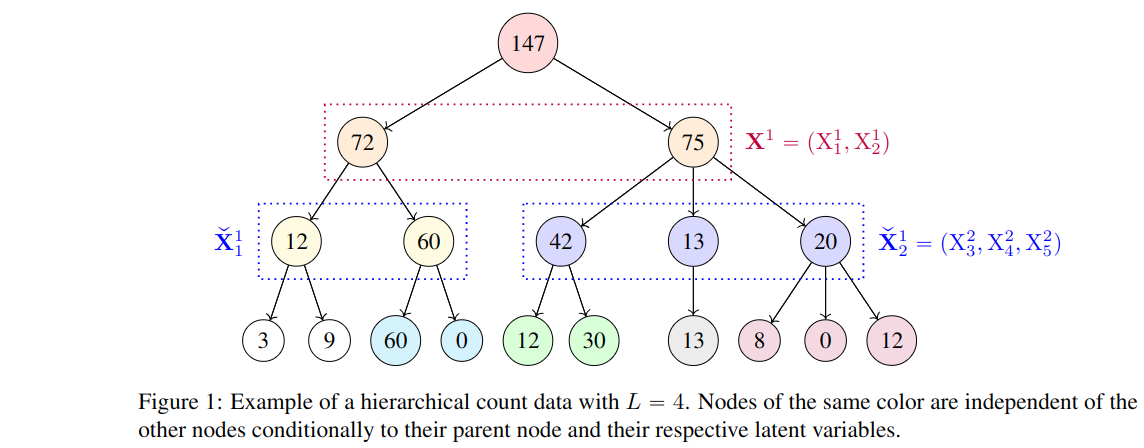

## How to load hierarchical data

Loading hierarchical data requires the following:
- Define a `plntree.utils.Tree` $\mathcal{T}$ as the underlying tree structure of your data.
- Provide a `torch.Tensor` $\mathbf{X}$ containing the counts at the each layer in shape $(n, L, K)$, such that $n$ is the of amount sample, $L$ the range of layers you want to analyze, $K$ the maximum number of nodes in the layers of the tree.

An example of how to define a `Tree` object from annotated data is thoroughly documented in the `plntree.data.metagenomics.get_taxonomy` method for importing the microbiome data of [Pasolli et al. (2016)](https://www.kaggle.com/datasets/antaresnyc/metagenomics). Please refer to it to create your `Tree` object from your count data.

You can also define a `Tree` object by hand through its constructor, by providing the tree graph adjacency matrix.
Be careful, the count data of the entity $k$ at a given layer $\ell$ of $\mathbf{X}$ have to match their node in the tree according to the node's `layer_index` argument (i.e. `node.layer_index` $= k$ for the entity $k$ at layer $\ell$).

## How to learn a PLN-Tree model

The `plntree.models.PLNTree` class is a `torch.nn.Module` object which contains several deep learning architectures that you can adjust to your liking. Once the architectures are selected, you can train the PLN-Tree model using `PyTorch` training procedure, preferrably using `torch.optim.Adam` optimizer.

## Example of usage: Microbiome data

### Utils import

In [1]:
# Importing regular data science libraries
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
# Seeding method for reproducibility. You can change that value.
from plntree.utils import seed_all

seed = 0
seed_all(seed)

### Importing the data

We import the data from the `plntree.data.metagenomics_loader` script. This includes the proportions of each bacteria present in the patients' gut, the taxonomy (hierarchical tree), and metadata on the patients (diseases associated).

We proceed to a filtering of the microbiome data associated with diseases, then a prevalence thresholding to limit spurious bacteria effects, and a resampling to convert the proportions into counts.

In [2]:
# Import the metagenomics loader script to get the Pasolli et al. (2016) dataset of microbiome data.
from plntree.data import metagenomics_loader

# Fetch the raw data (proportion data, all patients considered).
raw_abundances, metadata = metagenomics_loader.load_raw_data(directory='./plntree/data/metagenomics')
# Filter the patients with diseases for specific analysis.
diseases = [
    't2d', 
    'ibd_ulcerative_colitis', 
    'cirrhosis', 
    'ibd_crohn_disease', 
    'cancer', 
    'obesity', 
    'leaness'
]
raw_abundances, metadata = metagenomics_loader.filter_diseases(raw_abundances, metadata, diseases)

# Remove the Archaea and Eukaryota as the sequencing technology MetaPhlan2 is optimized for bacterial sequencing
filtered_taxa = ['k__Archaea', 'k__Eukaryota']

# Select the rarefaction offset.
# Resampling at exp(offset) of the counts using a multinomial.
# This is just a way to turn proportion data into count data.
rarefaction_offset = 12

# Select the prevalence threshold (-1 for none)
# This removes bacteria that are not present enough (below the prevalence threshold) to avoid spurious counts.
prevalence = 1 / np.exp(rarefaction_offset)

When importing the taxonomy, we select a level (precision) at which we want to conduct the analysis. In that case, we go as far as the "family" level.

In [3]:
# Select the taxonomic precision
precision = 'f'
# Define a prefix for future savings
prefix = f'metagenomics_classification_taxaL{precision}_s{seed}'

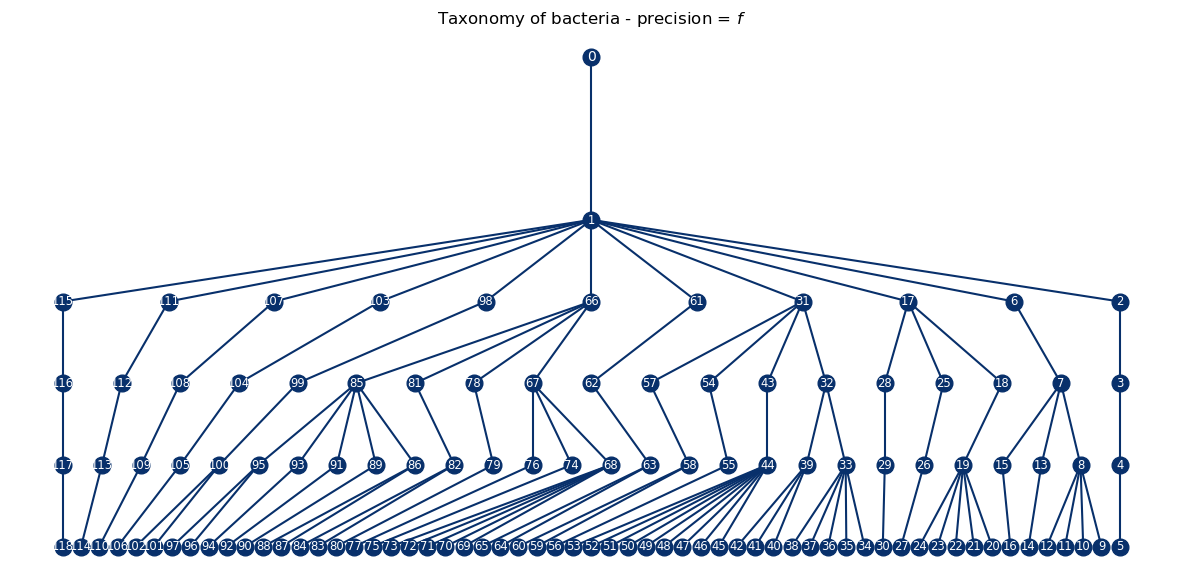

In [4]:
# Get the matrix of counts up to the chosen precision
abundances = metagenomics_loader.raw_abundance_filter(raw_abundances, precision)
for taxon in filtered_taxa:
    # Remove the counts associated with non-bacterial counts
    abundances = metagenomics_loader.exclude_taxon(abundances, taxon)
if prevalence > 0:
    # Perform the prevalence thresholding
    abundances = metagenomics_loader.prevalence_filter(abundances, threshold=prevalence)
# Perform the rarefaction (resampling)
abundances = metagenomics_loader.rarefy(abundances, rarefaction_offset, seed=seed)

# Compute the taxonomy
taxonomy = metagenomics_loader.get_taxonomy(abundances)
taxonomy.plot(legend=False, title=f'Taxonomy of bacteria - precision = ${precision}$')

Now, we turn the abundances into a `torch.utils.data.DataLoader` to be fed to a PLN-Tree architecture during training.

In [5]:
from torch.utils.data import DataLoader, TensorDataset

# Select the layers that we are going to look into
# Here, we start our analysis at the 3rd layer (order), up until the last layer (family)
selected_layers = [2, -1]

# We compute K the maximum number of nodes at these layers, then X the tensor of hierarchical counts
# X is of shape (n, L, K) with L = 3.
K = list(taxonomy.getLayersWidth().values())[selected_layers[0]:]
X_base, patient_ids = metagenomics_loader.hierarchical_dataset(abundances, taxonomy, offset_layer=selected_layers[0])

# Now we build the DataLoader
# Select the batch size
batch_size = len(X_base)
# Make sure to seed for reproducibility
seed_all(seed)
dataset = TensorDataset(X_base.to(dtype=torch.float64), X_base.to(dtype=torch.float64))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Learn a PLN-Tree model

Now that we have imported the data and formatted them according to the package, we can train a PLN-Tree architecture using the data loader.

In [6]:
# Import functions to save and load a model as a pickle file.
# This is not necessary, but PLN-Tree can be quite long to train, so save it if you do not want to start again!
from plntree.utils.jupyter_functions import save_pkl, load_pkl

2024-10-08 17:38:51.481140: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 17:38:51.482603: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 17:38:51.499999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 17:38:51.500026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 17:38:51.500638: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

First, we need to decide the kind of architecture we want to use in our model's latent dynamic. It is composed of two elements at each layer, the mean and the precision matrix of the Gaussian kernel, each taking the previous latent variable as input. Thus, technically, it would be necessary to design an appropriate neural network architecture at each layer of the tree to represent the mean and precision matrix of the Gaussian kernels.

For the sake of simplicity, this implementation provides only 1 hyper parameter to tune: the number of layers for both neural networks representing the mean and precision matrix. Thus, each parameter is represented by a fully connected feed forward neural network, with a fixed number of neurons per layer to the size of the input, and number of layers adjustable by the user. For further details, please see the original's paper Appendix.

In [7]:
# Number of latent layers in the each parameter of the latent process
n_latent_layers = 1

Similarly, we have to define the architecture we want to use for the variational approximation. When using the mean-field approximation, a similar approach of parameterization as for the latent process is used (see internal documentation). On the other hand, the backward variational approximation adds a layer of a Recurrent Neural Network (RNN) to encode the observed counts chain, which is patched to a similar architecture as the mean-field afterwards. The technicalities are left to explore for the readers within the code and paper.

In [8]:
# We define a function to obtain the RNN parameters and a string representation for future model's save
# We turn the count data to proportion before throwing them to the encoder,
preprocessing = 'proportion'
def embedder_params(
    embedder_type='GRU', # Type of RNN used, GRU or LSTM
    embedding_size=16, # Compression size of the chain X^{1:l}
    n_embedding_layers=2, # Number of recurrent layers
    n_embedding_neurons=32, # Number of neurons per recurrent layer
    n_after_layers=2 # Number of layers after the recursive part
):
    params = {
        'embedder_type': embedder_type,
        'embedding_size': embedding_size,
        'n_embedding_layers': n_embedding_layers,
        'n_embedding_neurons': n_embedding_neurons,
        'n_after_layers': n_after_layers,
        'preprocessing': [preprocessing]
    }
    name = f'Emb{embedder_type}-{n_embedding_layers}x{n_embedding_neurons}to{embedding_size}-{n_after_layers}'
    return name, params

# This is the architecture that we will use here
emb_name, variational_approx_params = embedder_params(
    embedding_size=32,
    n_embedding_layers=2,
    n_embedding_neurons=64,
    n_after_layers=2
)

We can now look into PLN-Tree's specific hyperparameters, and learn the model.

Loading file ./experiments/saves/metagenomics_classification_taxaLf_s0_residual_backward_proportion_1-EmbGRU-2x64to32-2.pkl
Loading file ./experiments/saves/metagenomics_classification_taxaLf_s0_residual_backward_proportion_1-EmbGRU-2x64to32-2.pkl


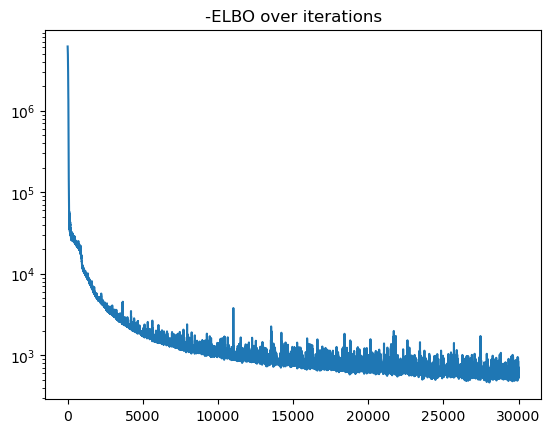

In [9]:
# Library for optimization in PyTorch
import torch.optim as optim
from plntree.models import PLNTree

# We design a function for learning PLN-Tree, this is not mandatory but easier to use when scaling.
def learn_plntree(n_latent_layers, variational_approx, variational_approx_params):
    estimator = PLNTree(
        tree=taxonomy, # Considered hierarchical structure
        selected_layers=selected_layers, # Where to look in the hierarchy (here between 'order' and 'family')
        diag_smoothing_factor=1e-4, # Smoothing factor for precision matrix stability (see Appendix paper)
        positive_fun='softplus', # Positive diagonal function for Cholesky decomposition (see Appendix paper)
        offset_method='constant', # Mode of the offset (constant or zero are equivalent)
        identifiable=True, # Whether or not to perform the identifiability projection (see paper)
        variational_approx=variational_approx, # The variational approximation used ('residual backward' here)
        variational_approx_params=variational_approx_params, # Parameters of the variational approximation
        n_latent_layers=n_latent_layers, # Parameters of the latent dynamic
        seed=seed # Reproducibility seed
    )
    # Define the optimizer
    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    estimator.to(dtype=torch.float64)
    # Number of iterations to perform
    n_epoch = 30_000
    # Learn the model
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

# Save or learn the model
backward, backward_losses = load_pkl(prefix, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}')
try:
    backward, backward_losses = load_pkl(prefix, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}')
except:
    print('Learning PLN-Tree (residual backward)')
    print(variational_approx_params)
    backward, backward_losses = learn_plntree(n_latent_layers, 'residual_backward', variational_approx_params)
    save_pkl((backward, backward_losses), prefix, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}')

# Plot the ELBO, to check convergence
fig, axs = plt.subplots()
axs.plot(backward_losses)
axs.set_title('-ELBO over iterations')
axs.set_yscale('log')

### PLN-Tree applications

After learning a PLN-Tree model on a dataset, we can perform several tasks such as data augmentation, preprocessing, interaction networks analysis, PCA, ...

Here, we present in a few lines how to sample from the PLN-Tree model to perform data augmentation, and how to preprocess data through the log-LTC transform for classification or PCA.

#### Data augmentation

Data augmentation consists in artificial create samples that resemble the true data. In our paper, we have shown that PLN-Tree is able to capture deeper patterns in the data that state-of-art model can not. Here, we showcase graphically how PLN-Tree outperform PLN and SPiEC-Easi in terms of alpha diversity on this microbiome dataset (see paper for more metrics).

In [10]:
# Select an augmentation size
n_augment = 50_000

We train PLN and SPiEC-Easi on the dataset before generating data with all models and comparing them on alpha diversity metrics.

Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 902 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 899 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 896 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 856 iterations
Likelihood: -45823.94618487358


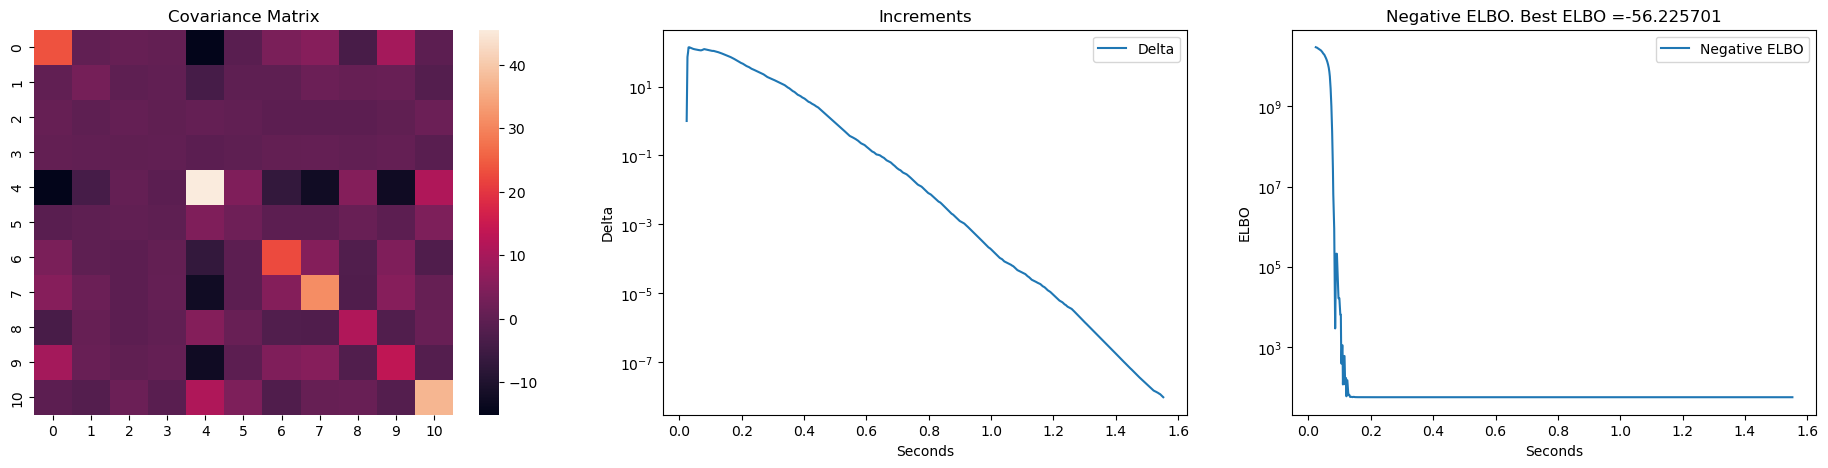

Likelihood: -81056.42355370522


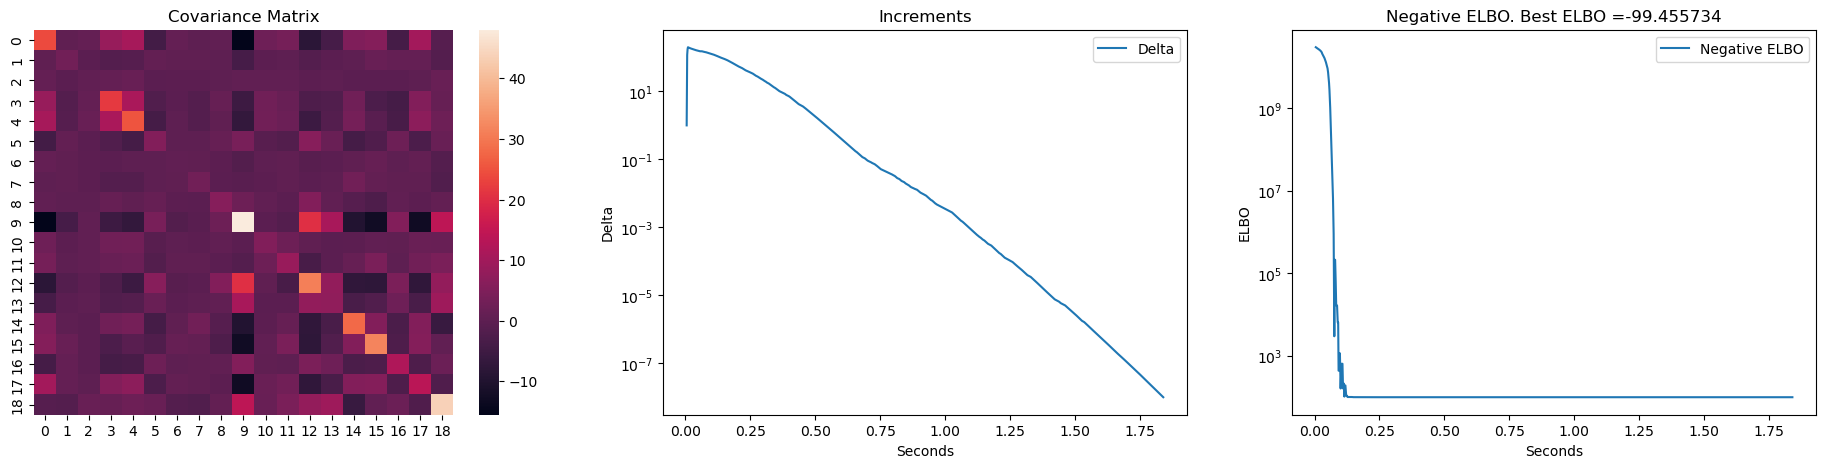

Likelihood: -96048.1193344593


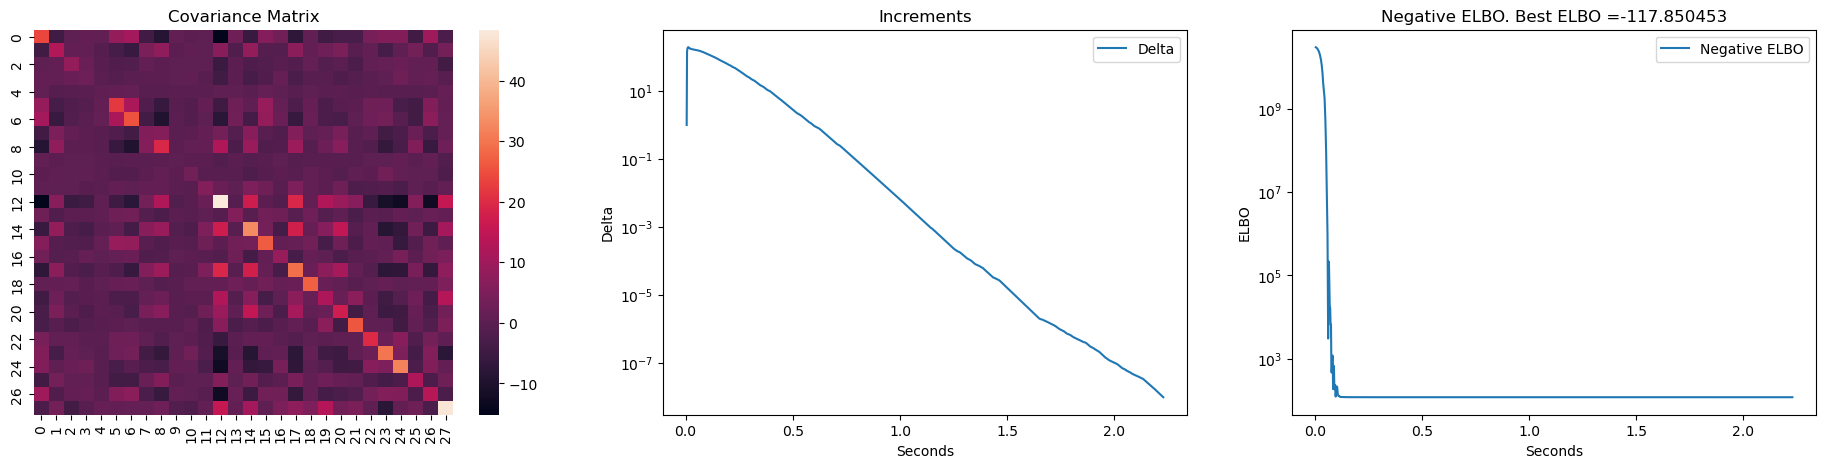

Likelihood: -182364.11846208572


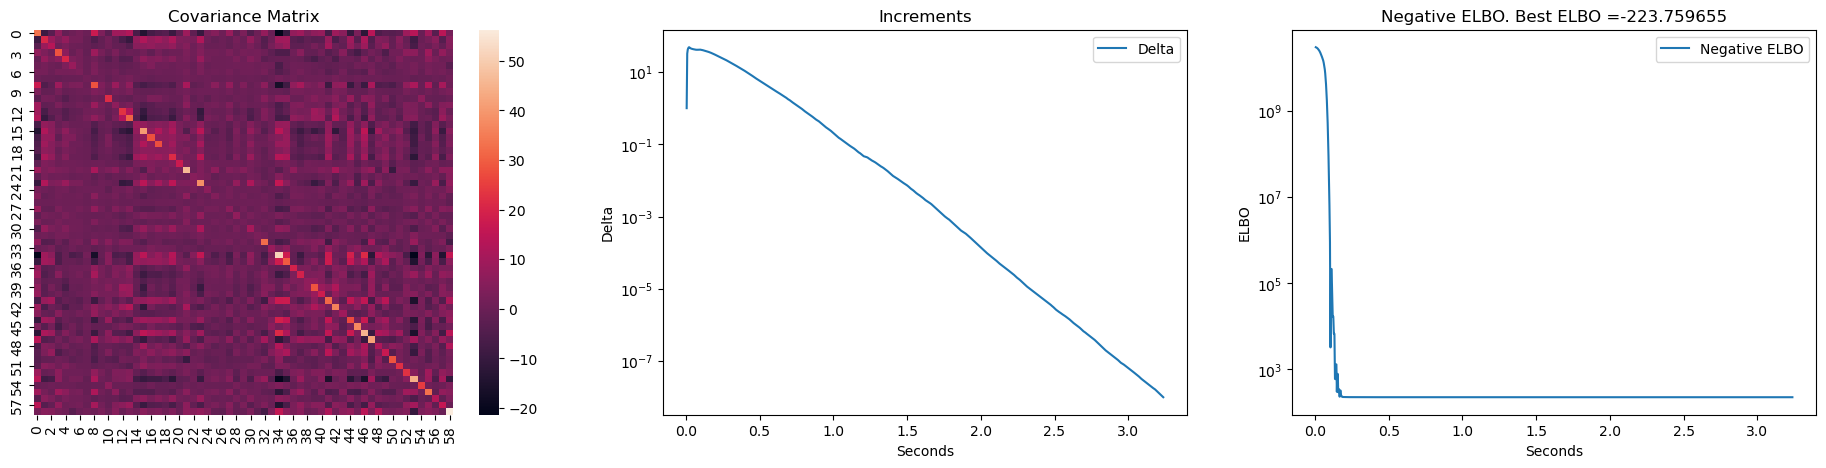

In [11]:
from plntree.utils.jupyter_functions import learn_pln, learn_per_layer_spiec_easi
# Train PLN at all layers, but we only keep the last one to create hierarchical count data
pln_layers = learn_pln(X_base, K, seed=seed)

In [12]:
from plntree.utils.jupyter_functions import to_proportion
# Train SPiEC-Easi at all layers, but we only keep the last one to create hierarchical count data
spiec_layers = learn_per_layer_spiec_easi(
    to_proportion(X_base, K), K, {'alpha':0.07, 'max_iter':10_000, 'mode':'cd'}, seed=seed
)

In [13]:
from plntree.utils.jupyter_functions import sample_model_layers, generate_pln_data
# Sample the amount of augmented data with the learned PLN-Tree model
X_plntree, Z_plntree, O_plntree = backward.sample(n_augment, seed=seed)
# Sample PLN augmented data
X_pln, Z_pln, X_pln_fill, X_pln_enc, Z_pln_enc, X_pln_enc_fill = generate_pln_data(pln_layers, n_augment, K, selected_layers, X_base, taxonomy, seed=seed)
# Sample with SPiEC-Easi
X_spiec, X_spiec_fill = sample_model_layers(spiec_layers, n_augment, K, selected_layers, taxonomy, seed=seed)

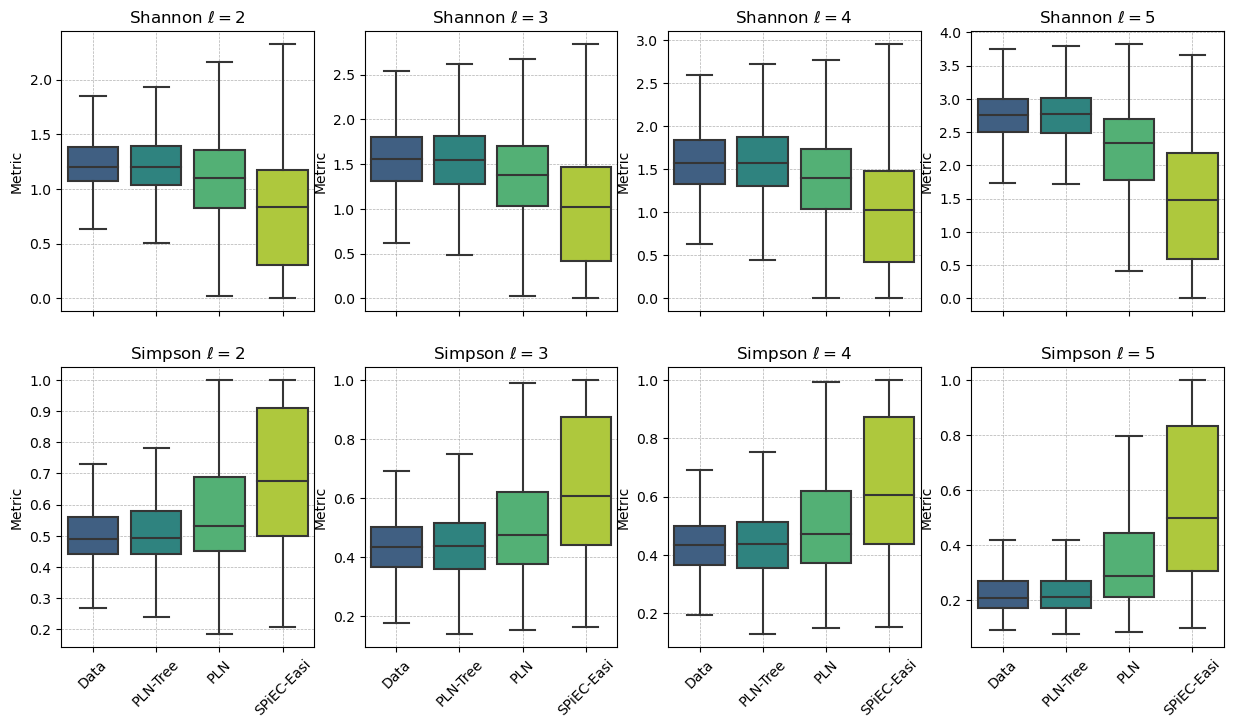

In [14]:
from plntree.utils.jupyter_functions import plot_alpha_diversity
from matplotlib.cm import viridis

X_list = (X_base, X_plntree, X_pln_fill, X_spiec_fill)
groups = ['Data', 'PLN-Tree', 'PLN', 'SPiEC-Easi']
colors = [viridis(0.3), viridis(0.5), viridis(0.7), viridis(0.9)]
# Visually plot the alpha diversity at each layer. The closest to the original data wins.
plot_alpha_diversity(
    X_list,
    taxonomy,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

#### Data preprocessing with log-LTC

In our paper, we suggested a latent feature called log-LTC in the wake of usual log-transforms for compositional data analysis. In this context, we show how to use the log-LTC to encode compositional microbiome data for later use in PCA for instance.

In [15]:
# We encode the training dataset into their latent representation.
Z_encode, O_encode = backward.encode(X_base)

In [16]:
# Turn the latent representation into the LTC-transformed, and take the log.
Z_ltc = backward.latent_tree_counts(Z_encode)
Z_log_ltc = torch.log(Z_ltc).detach()

In [17]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

# We prepare a PCA 2D plot of the data
Y_base = metadata['disease']
def plot_pca(Y_base, X_base):
    fig, axs = plt.subplots(1, len(K), figsize=(15, 4))
    colors = [matplotlib.cm.get_cmap('viridis')((i+1)/len(np.unique(Y_base))) for i, name in enumerate(np.unique(Y_base))]
    for layer, K_l in enumerate(K):
        X_l = X_base[:, layer, :K_l]
        pca = PCA(n_components=2, random_state=seed).fit(X_l)
        X_l_pca = pca.transform(X_l)
        for k, c in enumerate(np.unique(Y_base)):
            indexes = np.where(Y_base == c)
            axs[layer].set_title(f'$\ell = {layer + selected_layers[0]}$')
            axs[layer].plot(X_l_pca[indexes, 0], X_l_pca[indexes, 1], marker='.', linestyle='', color=colors[k], alpha=0.5)
            axs[layer].set_xlabel(f'axis 1 ({np.round(pca.explained_variance_ratio_[0] * 100, 1)}%)')
            axs[layer].set_ylabel(f'axis 2 ({np.round(pca.explained_variance_ratio_[1] * 100, 1)}%)')
    legend_handles = [
            mlines.Line2D([], [], marker='o', linestyle='', color=color, alpha=0.9, label=group)
            for color, group in zip(colors, np.unique(Y_base))
        ]
    legend = plt.legend(handles=legend_handles, fontsize="12", loc='lower center', bbox_to_anchor=(-1.65, -0.32), ncols=len(colors))
    plt.subplots_adjust(wspace=0.4)

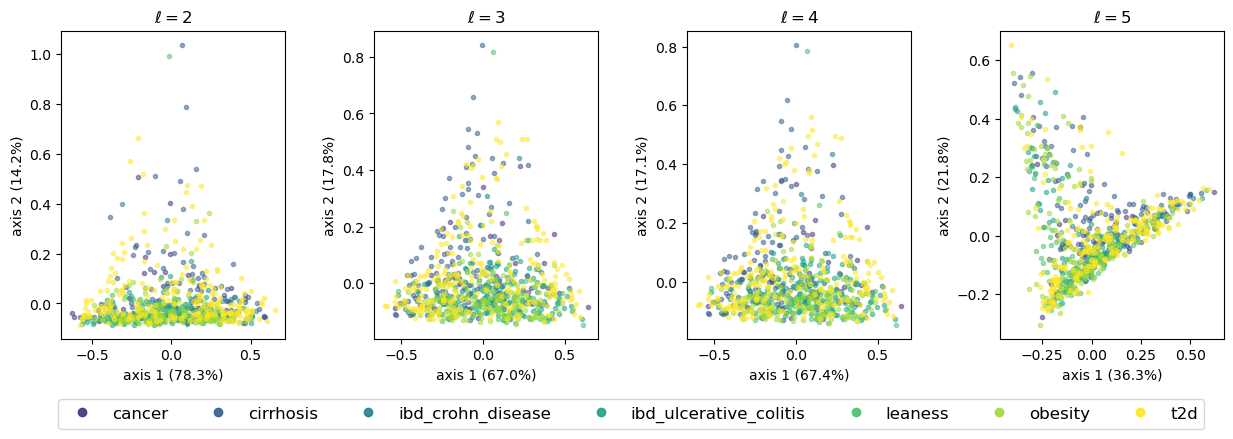

In [18]:
# First we look at the PCA when using the proportions
X_proportion = X_base / X_base[:, 0].sum(dim=-1, keepdims=True).unsqueeze(-1)
plot_pca(Y_base, X_proportion)

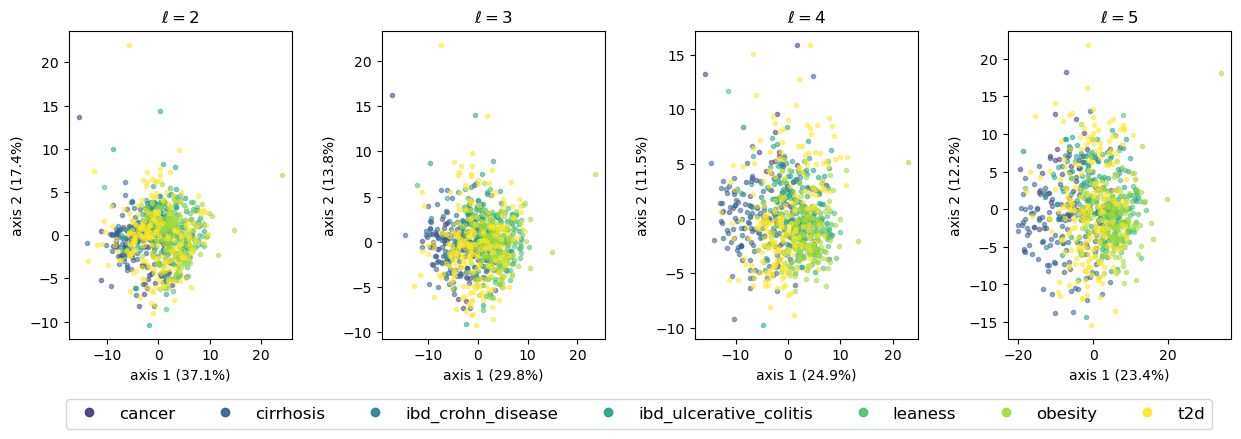

In [19]:
# We plot the PCA when using the log-LTC
plot_pca(Y_base, Z_log_ltc)